In [32]:
import os
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import xml.etree.ElementTree as etree
import skimage
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
import math

from IPython.display import display 

In [2]:
#Parsetja el fitxer xml i recupera la informació necessaria per trobar la cara de l'animal
#
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    :return annotation: diccionari
    """
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    dds = []
    for obj in objects:
        dds.append(obj.find('name').text)
        dds.append([int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))])

    return {'size': size, 'informacio': dds}

# Selecciona la cara de l'animal i la transforma a la mida indicat al paràmetre mida_desti
def retall_normalitzat(imatge, dades, mida_desti=(64,64)):
    """
    Extreu la regió de la cara (ROI) i retorna una nova imatge de la mida_destí
    :param imatge: imatge que conté un animal
    :param dades: diccionari extret del xml
    :mida_desti: tupla que conté la mida que obtindrà la cara de l'animal
    """
    x, y, ample, alt = dades['informacio'][1]
    retall = np.copy(imatge[y:alt, x:ample])
    return resize(retall, mida_desti)

def obtenir_dades(carpeta_imatges, carpeta_anotacions, mida=(64, 64)):
    """Genera la col·lecció de cares d'animals i les corresponents etiquetes
    :param carpeta_imatges: string amb el path a la carpeta d'imatges
    :param carpeta_anotacions: string amb el path a la carpeta d'anotacions
    :param mida: tupla que conté la mida que obtindrà la cara de l'animal
    :return:
        images: numpy array 3D amb la col·lecció de cares
        etiquetes: llista binaria 0 si l'animal és un moix 1 en cas contrari
    """

    n_elements = len([entry for entry in os.listdir(carpeta_imatges) if os.path.isfile(os.path.join(carpeta_imatges, entry))])
    # Una matriu 3D: mida x mida x nombre d'imatges
    imatges = np.zeros((mida[0], mida[1], n_elements), dtype=np.float16)
    # Una llista d'etiquetes
    etiquetes = [0] * n_elements

    #  Recorre els elements de les dues carpetes: llegeix una imatge i obté la informació interessant del xml
    with os.scandir(carpeta_imatges) as elements:

        for idx, element in enumerate(elements):
            nom = element.name.split(".")
            nom_fitxer = nom[0] + ".xml"
            imatge = imread(carpeta_imatges + os.sep + element.name, as_gray=True)
            anotacions = extract_xml_annotation(carpeta_anotacions + os.sep + nom_fitxer)

            cara_animal = retall_normalitzat(imatge, anotacions, mida)
            tipus_animal = anotacions["informacio"][0]

            imatges[:, :, idx] = cara_animal
            etiquetes[idx] = 0 if tipus_animal == "cat" else 1

    return imatges, etiquetes

Obtendremos los datos de las imagenes y las etiquetas y las guardaremos en un archivo .npy

In [3]:
""" Función para obtener los datos, extraer características HoG y guardarlas en un archivo. """
carpeta_images = "gatigos/images"  # NO ES POT MODIFICAR
carpeta_anotacions = "gatigos/annotations"  # NO ES POT MODIFICAR
mida = (64, 64)  # DEFINEIX LA MIDA, ES RECOMANA COMENÇAR AMB 64x64

# Obtener imágenes, etiquetas
imatges, etiquetes = obtenir_dades(carpeta_images, carpeta_anotacions, mida)

# Guardar etiquetas y nombres de archivo para sincronización en el procesamiento
np.save("files/etiquetas.npy", etiquetes)
np.save("files/imagenes.npy", imatges)

## Configuración HOG

Antes de entrenar al modelo, hemos de extraer las características de la imagen con un HOG. Para ello, hemos hecho una búsqueda de los mejores parámetros para el HOG y los hemos guardado en un archivo .npy para luego cargarlos en el entrenamiento.

In [20]:
visualitzar = False  # Modificar a True para visualizar las imágenes

def obtenirHoG(imagen, ppc = (8, 8), cpb = (2, 2), o = 9):
    """ Función para extraer características HoG de una sola imagen y mostrarla. """
    
    # Extraer HoG de la imagen
    caracteristicas, imagenHOG = skimage.feature.hog(imagen, 
                                                     pixels_per_cell=ppc, 
                                                     cells_per_block= cpb, 
                                                     orientations = o,       # Sirve para dividir el rango de ángulos en subrangos
                                                     feature_vector = True,  # Devuelve un vector de características
                                                     visualize = True)       # Devuelve la imagen HoG
    
    # Mostrar imagen original y HoG
    if visualitzar:
        _, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
        ax[0].imshow(imagen)
        ax[0].set_title('Imagen Original')
        
        ax[1].imshow(imagenHOG)
        ax[1].set_title('Imagen HOG')
        
        plt.show()

    return caracteristicas  # Devuelve las características HoG como vector



# Definir las configuraciones de HoG:
hog_configs = [
    #{'ppc': (4, 4), 'cpb': (2, 2), 'o': 9},
    #{'ppc': (4, 4), 'cpb': (8, 8), 'o': 9},
    #{'ppc': (6, 6), 'cpb': (2, 2), 'o': 9},
    {'ppc': (8, 8), 'cpb': (2, 2), 'o': 9}
    #{'ppc': (8, 8), 'cpb': (2, 2), 'o': 18}
]

# Probar cada configuración en todas las imágenes
for config in hog_configs:
    
    features_list = []
    
    for i in range(imatges.shape[2]): # Iterar sobre todas las imágenes
        # Obtener características HoG para cada imagen
        caracteristiques = obtenirHoG(imatges[:,:,i], 
                                      ppc = config['ppc'], 
                                      cpb = config['cpb'], 
                                      o = config['o'])
        
        features_list.append(caracteristiques)
    
    # Convertir la lista de características en un array numpy
    caracteristiques_hog = np.array(features_list)
    
    # Guardar las características de cada configuración en un archivo
    filename = f"files/caracteristiques_hog_ppc{config['ppc'][0]}_cpb{config['cpb'][0]}_o{config['o']}.npy"
    np.save(filename, caracteristiques_hog)
    print(f"Guardadas todas las características en {filename}")

Guardadas todas las características en ./files/caracteristiques_hog_ppc8_cpb2_o9.npy


## Entrenamiento

### Obtención de train y test

Para obtener los datos de entrenamiento y test, hemos de cargar las imágenes y las etiquetas de los archivos .npy que hemos guardado previamente. Una vez cargados, hemos de dividirlos en train y test. En este caso, hemos decidido hacer un 80% de train y un 20% de test.

In [4]:
# Cargar características y etiquetas en el orden correcto:
caracteristicas = np.load("files/caracteristiques_hog_ppc8_cpb2_o9.npy")
etiquetas = np.load("files/etiquetas.npy")

# Separación de los datos en entrenamiento y prueba manteniendo sincronización
X_train, X_test, y_train, y_test = train_test_split(
    caracteristicas, etiquetas, test_size=0.2, random_state=42)

Para poder tratar con los datos correctamente, procederemos a normalizarlos.

In [5]:
# Estandarización de los datos:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

## Busqueda de hiperparámetros (GridSearchCV)

In [ ]:
param_kernels = {
    'rbf': {'kernel': ['rbf'], 'C': [3.5, 3], 'gamma': ['scale', 'auto'], 'tol': [1.5, 1], 'max_iter': [2000, 2500]},
    'linear': {'kernel': ['linear'], 'C': [9e-5, 1e-4, 11e-5, 0.001, 0.01], 'tol': [1.5, 1, 0.1, 1e-2], 'max_iter': [250, 500, 1000, 2000]},
    'poly': {'kernel': ['poly'], 'C': [0.85, 1], 'degree': [1, 2], 'gamma': ['scale', 'auto'], 'coef0': [0.1, 0.15, 0.2], 'max_iter': [1500, 1000], 'tol': [0.75, 0.5]},
}

best_models = {}
# Buscar los mejores parámetros para cada kernel
for kernel in param_kernels.keys():
    print(f"Entrenando modelo SVM con kernel {kernel}")
    start_time = time.time()

    svm = SVC()
    # n_jobs=-1 para utilizar todos los núcleos del procesador
    grid_search = GridSearchCV(svm, param_kernels[kernel], cv=5, n_jobs=-1)

    grid_search.fit(X_transformed, y_train)

    best_models[kernel] = grid_search.best_estimator_
    print(f"Entrenamiento finalizado en {time.time() - start_time:.2f} segundos")
    print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor precisión encontrada: {grid_search.best_score_}") 
    print("---------------------------------------------------")

for kernel, model in best_models.items():
    y_pred = model.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión del modelo SVM con kernel {kernel}: {accuracy:.3f}")
    print("---------------------------------------------------")

### Entrenamiento de los mejores modelos

In [37]:
def cargar_Imagenes(indices, img_list, y_true, y_pred, titulo):
    """ Función para cargar y mostrar imágenes clasificadas correctamente e incorrectamente. """
    
    n_imagenes = len(indices)
    num_columnas = min(8, n_imagenes)
    num_filas = math.ceil(n_imagenes / num_columnas)

    fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, num_filas * 2.5), sharex=True, sharey=True)
    fig.suptitle(titulo)

    for i, idx in enumerate(indices):
        row = i // num_columnas
        col = i % num_columnas

        axes[row, col].imshow(img_list[idx], cmap='gray')
        axes[row, col].set_title(f'Pred: {y_pred[idx]} - Real: {y_true[idx]}')
        axes[row, col].axis('off')

    # Ocultar las subtramas vacías
    for j in range(i + 1, num_filas * num_columnas):
        fig.delaxes(axes.flatten()[j])


    plt.show()
    return

def imagenes_Clasificadas(y_test, y_pred, img_test, nImagenes=5, kernel=''):
    """Función para mostrar imágenes clasificadas correctamente e incorrectamente."""

    # Obtener índices de imágenes clasificadas correctamente e incorrectamente:
    correctas = np.where(y_test == y_pred)[0][:nImagenes]
    incorrectas = np.where(y_test != y_pred)[0][:nImagenes]

    # Mostrar las imágenes
    cargar_Imagenes(correctas, img_test, y_test, y_pred, f"Imágenes Bien Clasificadas con kernel {kernel}")
    cargar_Imagenes(incorrectas, img_test, y_test, y_pred, f"Imágenes Mal Clasificadas con kernel {kernel}")

    return

----- Evaluando Modelo SVM con kernel Linear -----
Exactitud: 0.890
Precisión: 0.889
Sensibilidad: 0.890
F1: 0.889

-- Testeo por si hay overfitting o underfitting --
Accuracy en entrenamiento: 0.920
Accuracy en prueba: 0.890
Diferencia: 0.030 - El modelo parece tener un buen equilibrio entre entrenamiento y prueba.
-------------------------------------------------------------------------------------------------



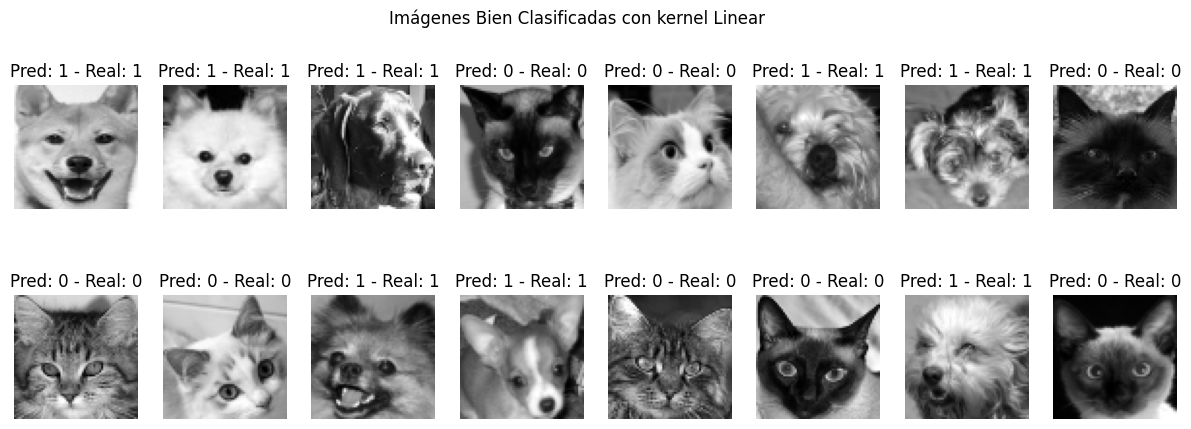

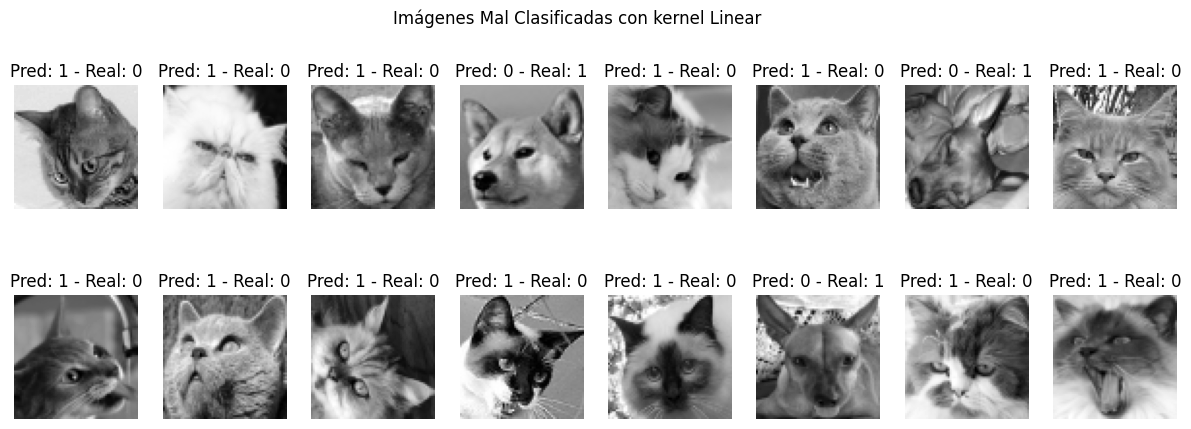

----- Evaluando Modelo SVM con kernel Poly -----
Exactitud: 0.935
Precisión: 0.935
Sensibilidad: 0.935
F1: 0.934

-- Testeo por si hay overfitting o underfitting --
Accuracy en entrenamiento: 0.998
Accuracy en prueba: 0.935
Diferencia: 0.063 - El modelo parece tener un buen equilibrio entre entrenamiento y prueba.
-------------------------------------------------------------------------------------------------



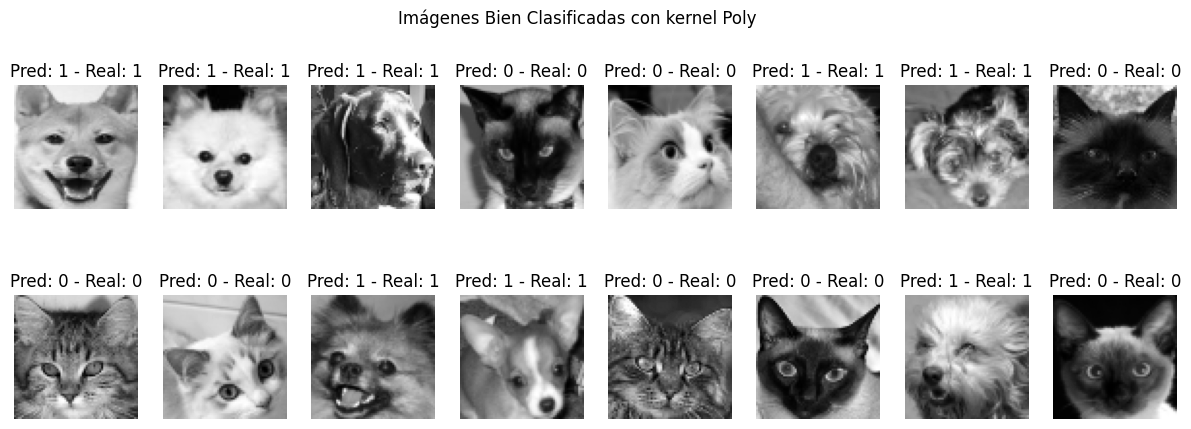

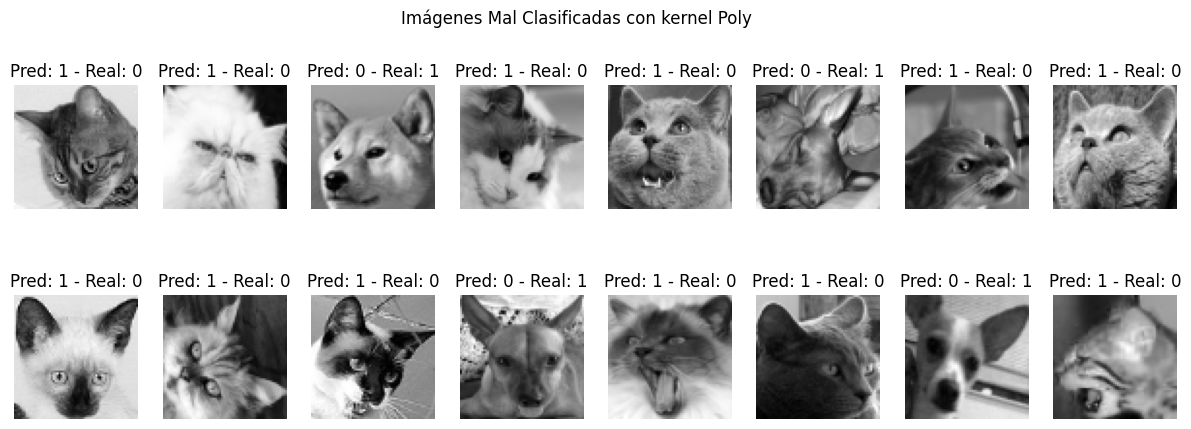

----- Evaluando Modelo SVM con kernel RBF -----
Exactitud: 0.930
Precisión: 0.929
Sensibilidad: 0.930
F1: 0.929

-- Testeo por si hay overfitting o underfitting --
Accuracy en entrenamiento: 1.000
Accuracy en prueba: 0.930
Diferencia: 0.070 - El modelo parece tener un buen equilibrio entre entrenamiento y prueba.
-------------------------------------------------------------------------------------------------



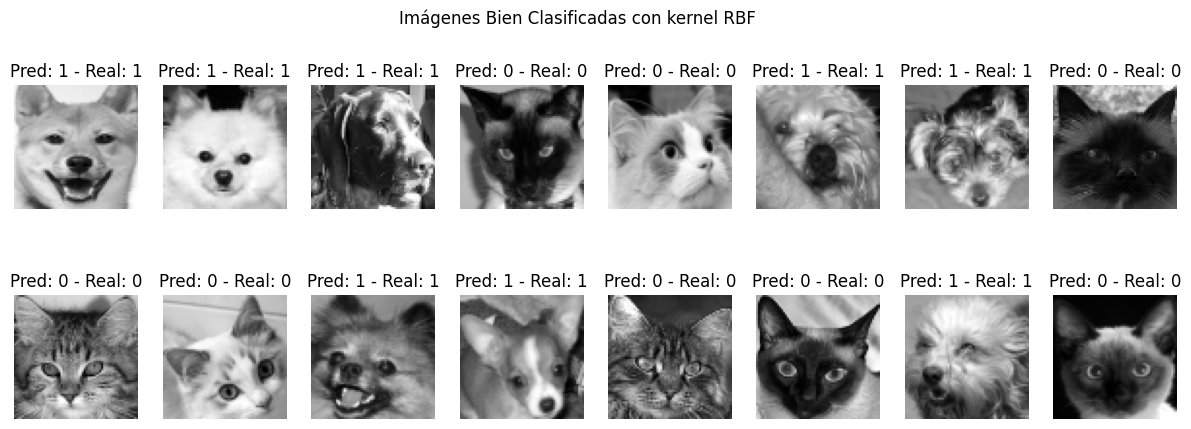

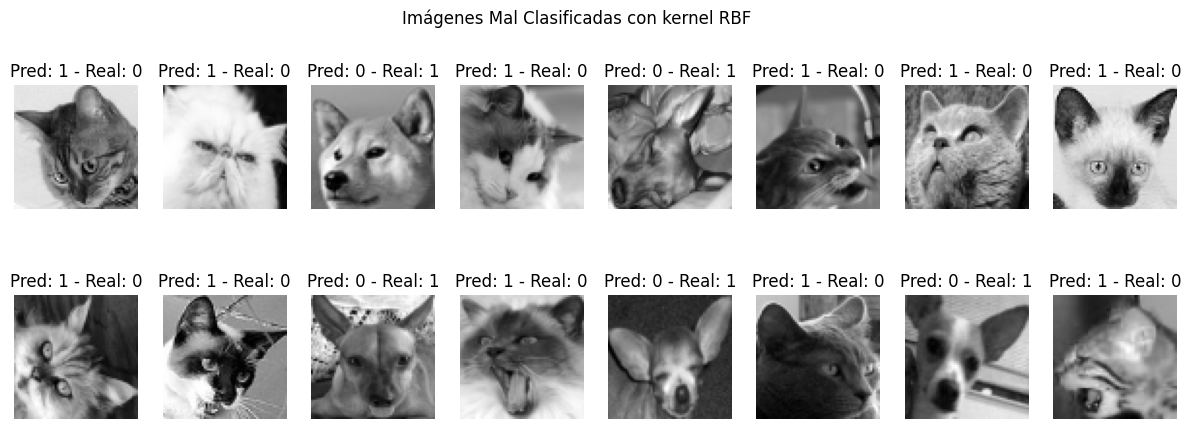

In [39]:
def calcular_metricas(y_test, y_pred):
    """ Función para calcular la precisión, sensibilidad, F1 y exactitud de cada modelo. """

    precision = precision_score(y_test, y_pred, average='weighted')
    sensibilidad = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    exactitud = accuracy_score(y_test, y_pred)
    
    return precision, sensibilidad, f1, exactitud

def train_and_evaluate_fix_model(X_transformed, y_train, X_test_transformed, y_test, params):
    """ Función para entrenar un modelo SVM con parámetros fijos y evaluarlo. """
    
    svm = SVC(**params) # Los '**' sirven para desempaquetar el diccionario de parámetros
    svm.fit(X_transformed, y_train)
    y_pred = svm.predict(X_test_transformed)

    # Cálculo de las métricas 'Precision' - 'Recall' - 'F1' - 'Accuracy'
    precision, sensibilidad, f1, exactitud = calcular_metricas(y_test, y_pred)

    print(f"Exactitud: {exactitud:.3f}")
    print(f"Precisión: {precision:.3f}")
    print(f"Sensibilidad: {sensibilidad:.3f}")
    print(f"F1: {f1:.3f}\n")


    # Evaluar si el modelo está sobreajustando o subajustando
    y_train_pred = svm.predict(X_transformed)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = exactitud  # Ya calculada anteriormente

    print(f"-- Testeo por si hay overfitting o underfitting --")
    print(f"Accuracy en entrenamiento: {train_accuracy:.3f}")
    print(f"Accuracy en prueba: {test_accuracy:.3f}")

    diferencia = abs(train_accuracy - test_accuracy)

    if train_accuracy > 0.95 and test_accuracy < 0.80:
        print(f"Diferencia: {diferencia:.3f} - El modelo podría estar sobreajustando (overfitting).")
    
    elif train_accuracy < 0.80 and test_accuracy < 0.80:
        print(f"Diferencia: {diferencia:.3f} - El modelo podría estar subajustando (underfitting).")
    
    else:
        print(f"Diferencia: {diferencia:.3f} - El modelo parece tener un buen equilibrio entre entrenamiento y prueba.")
    
    print("-------------------------------------------------------------------------------------------------\n")

    return y_pred, precision, sensibilidad, f1, exactitud

# Mejores parámetros para cada kernel:
best_params_poly = {
    'kernel': 'poly',
    'C': 1,
    'degree': 2,
    'gamma': 'auto',
    'coef0': 0.1,
    'tol': 0.5,
    'max_iter': 1500
}

best_params_linear = {
    'kernel': 'linear',
    'C': 0.0001,
    'tol': 1,
    'max_iter': 500
}

best_params_rbf = {
    'kernel': 'rbf',
    'C': 3,
    'gamma': 'scale',
    'tol': 1,
    'max_iter': 2000
}

# Definir los modelos y sus parámetros
modelos = [
    ('Linear', best_params_linear),
    ('Poly', best_params_poly),
    ('RBF', best_params_rbf)
]

# Crear tabla comparativa y gráfico con los resultados obtenidos:
resultados = []

# Cargar imágenes de prueba y transformarlas con la estructura (n_imagenes, n_filas, n_columnas)
imagenes = np.load("files/imagenes.npy").transpose(2, 0, 1)
_, img_test = train_test_split(imagenes, test_size=0.2, random_state=42)

# Evaluación de los modelos SVM obtenidos con los mejores parámetros
for nombre, params in modelos:
    print(f"----- Evaluando Modelo SVM con kernel {nombre} -----")
    y_pred, precision, sensibilidad, f1, exactitud = train_and_evaluate_fix_model(X_transformed, y_train, X_test_transformed, y_test, params)
    resultados.append([nombre, precision, sensibilidad, f1, exactitud])

    # Mostrar imágenes clasificadas correctamente e incorrectamente
    imagenes_Clasificadas(y_test, y_pred, img_test, nImagenes=16, kernel=nombre)

## Resultados

In [30]:
def contar_muestras(data):
    """ Cuenta el número de muestras de cada clase. """
    
    clases, conteo = np.unique(data, return_counts=True)
    
    print("Número de muestras por clase (0 -> Gato, 1 -> Perro):")
    for clase, num in zip(clases, conteo):
        print(f"Clase {clase}: {num} ")

    print("\n")
    return

contar_muestras(y_test)

Número de muestras por clase (0 -> Gato, 1 -> Perro):
Clase 0: 252 
Clase 1: 486 




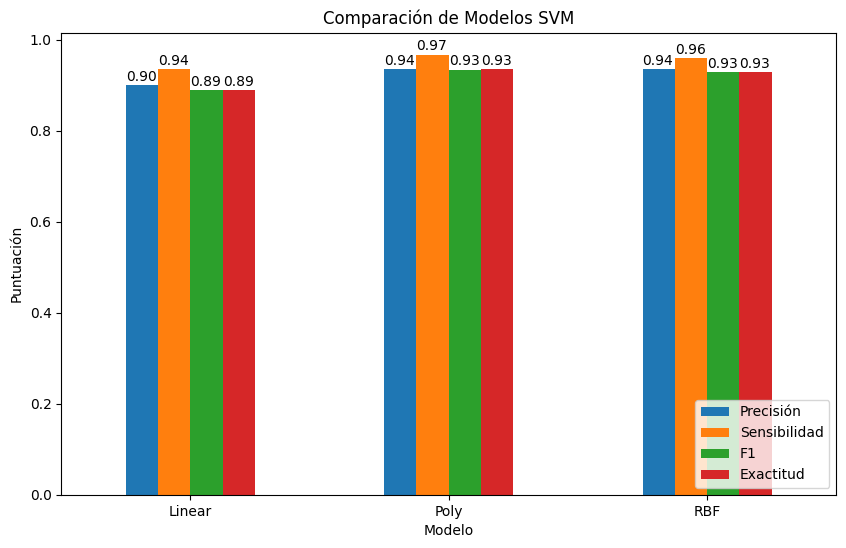

In [32]:
""" Construye una tabla comparativa y un gráfico con los resultados obtenidos. """
# Crear la tabla comparativa
df_resultados = pd.DataFrame(resultados, columns=['Modelo', 'Precisión', 'Sensibilidad', 'F1', 'Exactitud'])

# Crear el gráfico
ax = df_resultados.set_index('Modelo').plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Modelos SVM')
plt.ylabel('Puntuación')
plt.xticks(rotation=0)
plt.legend(loc='lower right')

# Añadir etiquetas con los valores a las barras:
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x(), p.get_height() * 1.01))

plt.show()

In [33]:
display(df_resultados)  # Usa display para visualizar mejor la tabla en Jupyter

,Modelo,Precisión,Sensibilidad,F1,Exactitud
0,Linear,0.900990,0.936214,0.889146,0.890244
1,Poly,0.936255,0.967078,0.934420,0.934959
2,RBF,0.935743,0.958848,0.929110,0.929539
